In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
from PIL import Image
from pathlib import Path
from tqdm import tqdm

from torchvision import datasets, models
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}
Training Set distribution: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Validation Set distribution: {'NORMAL': 8, 'PNEUMONIA': 8}
Test Set distribution: {'NORMAL': 234, 'PNEUMONIA': 390}


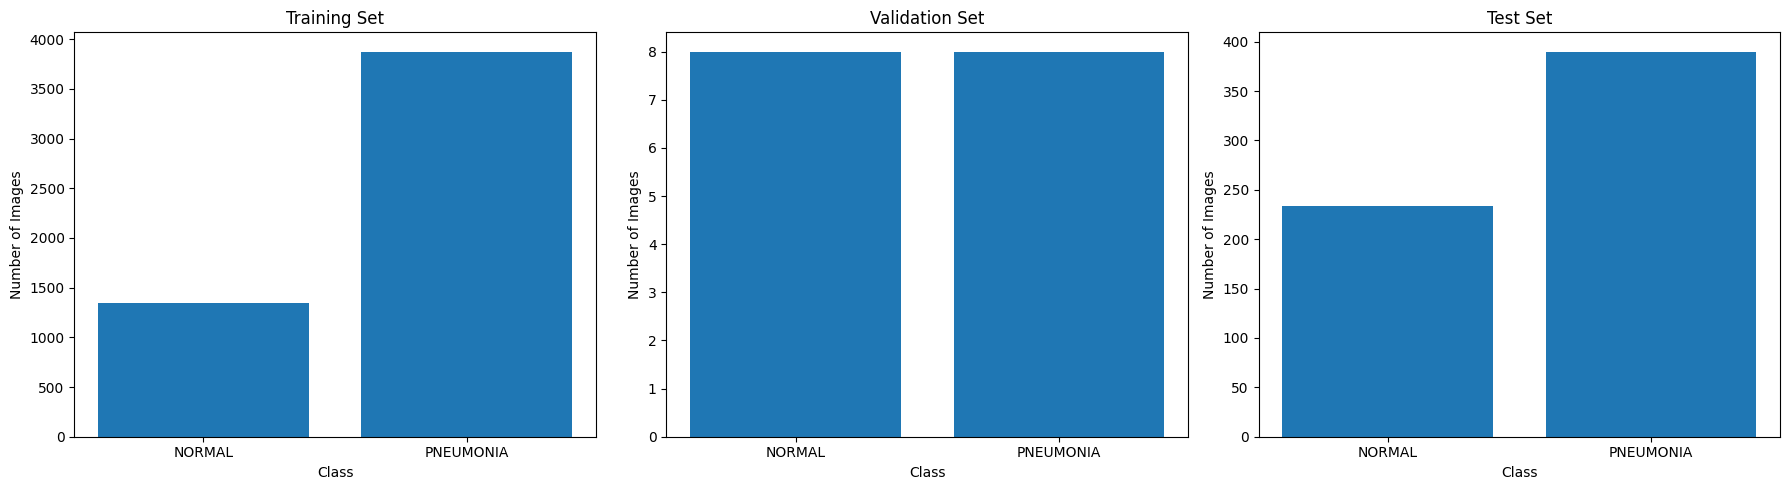

In [7]:
base_dir = '/cluster/scratch/gcardenal/ml4h_project2/dataset/chest_xray'

# Load datasets
train_set = datasets.ImageFolder(os.path.join(base_dir, 'train'))
validation_set = datasets.ImageFolder(os.path.join(base_dir, 'val'))
test_set = datasets.ImageFolder(os.path.join(base_dir, 'test'))

class_names = train_set.classes
print(class_names)
print(train_set.class_to_idx)

# Modified function to use subplots
def check_all_label_distributions(train, val, test):
    datasets_list = [(train, 'Training Set'), (val, 'Validation Set'), (test, 'Test Set')]
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, (dataset, title) in enumerate(datasets_list):
        counts = [0] * len(dataset.classes)
        for _, label in dataset:
            counts[label] += 1
        axs[i].bar(dataset.classes, counts)
        axs[i].set_title(title)
        axs[i].set_ylabel('Number of Images')
        axs[i].set_xlabel('Class')
        print(f"{title} distribution:", dict(zip(dataset.classes, counts)))

    plt.tight_layout()
    plt.savefig("dataset_class_distribution.png")
    plt.show()

check_all_label_distributions(train_set, validation_set, test_set)

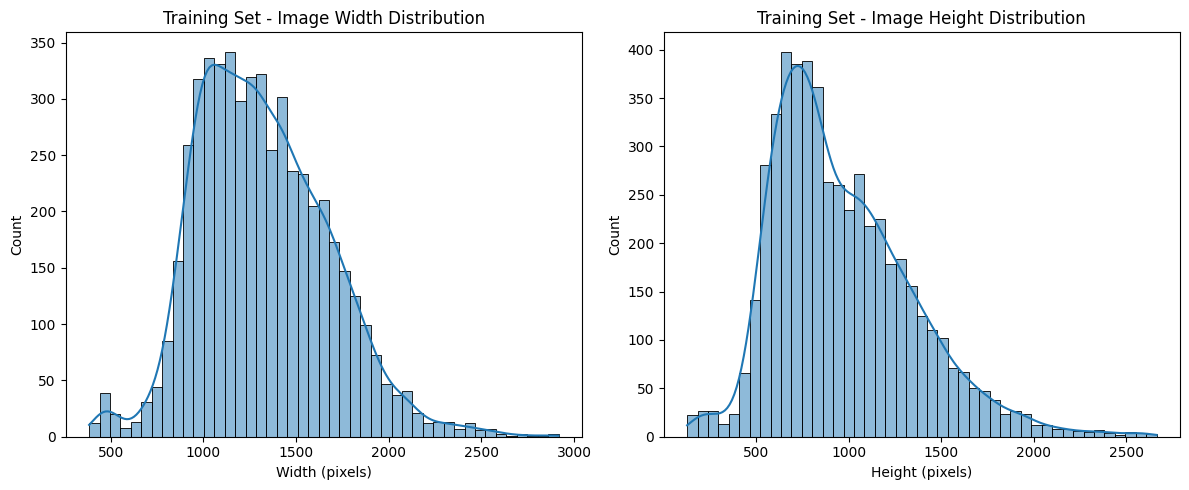

In [8]:
def plot_size_distribution(dataset, title):
    widths, heights = [], []
    for img_path, _ in dataset.imgs:
        with Image.open(img_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(widths, kde=True)
    plt.title(f'{title} - Image Width Distribution')
    plt.xlabel('Width (pixels)')
    
    plt.subplot(1, 2, 2)
    sns.histplot(heights, kde=True)
    plt.title(f'{title} - Image Height Distribution')
    plt.xlabel('Height (pixels)')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_size_distribution(train_set, "Training Set")

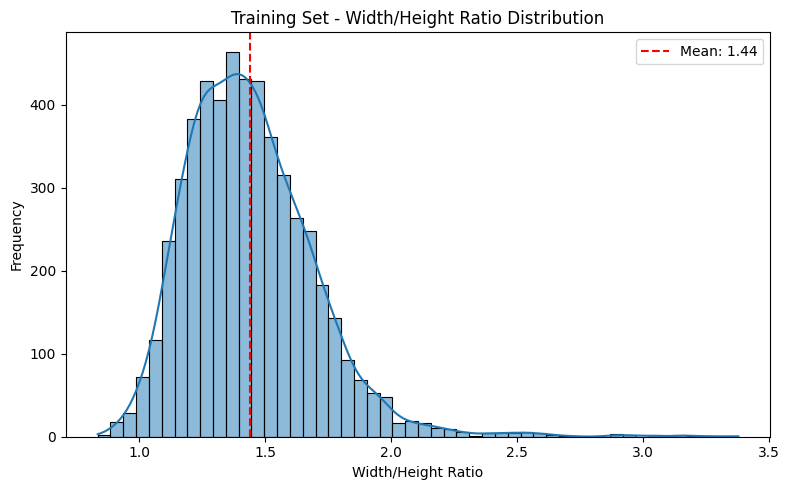

In [9]:
def plot_ratio_distribution(dataset, title):
    ratios = []
    for img_path, _ in dataset.imgs:
        with Image.open(img_path) as img:
            width, height = img.size
            ratios.append(width / height)

    plt.figure(figsize=(8, 5))
    sns.histplot(ratios, bins=50, kde=True)
    plt.title(f'{title} - Width/Height Ratio Distribution')
    plt.xlabel('Width/Height Ratio')
    plt.ylabel('Frequency')
    plt.axvline(x=np.mean(ratios), color='red', linestyle='--', label=f'Mean: {np.mean(ratios):.2f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig("dataset_ratio_distribution.png")
    plt.show()

# Example usage:
plot_ratio_distribution(train_set, "Training Set")

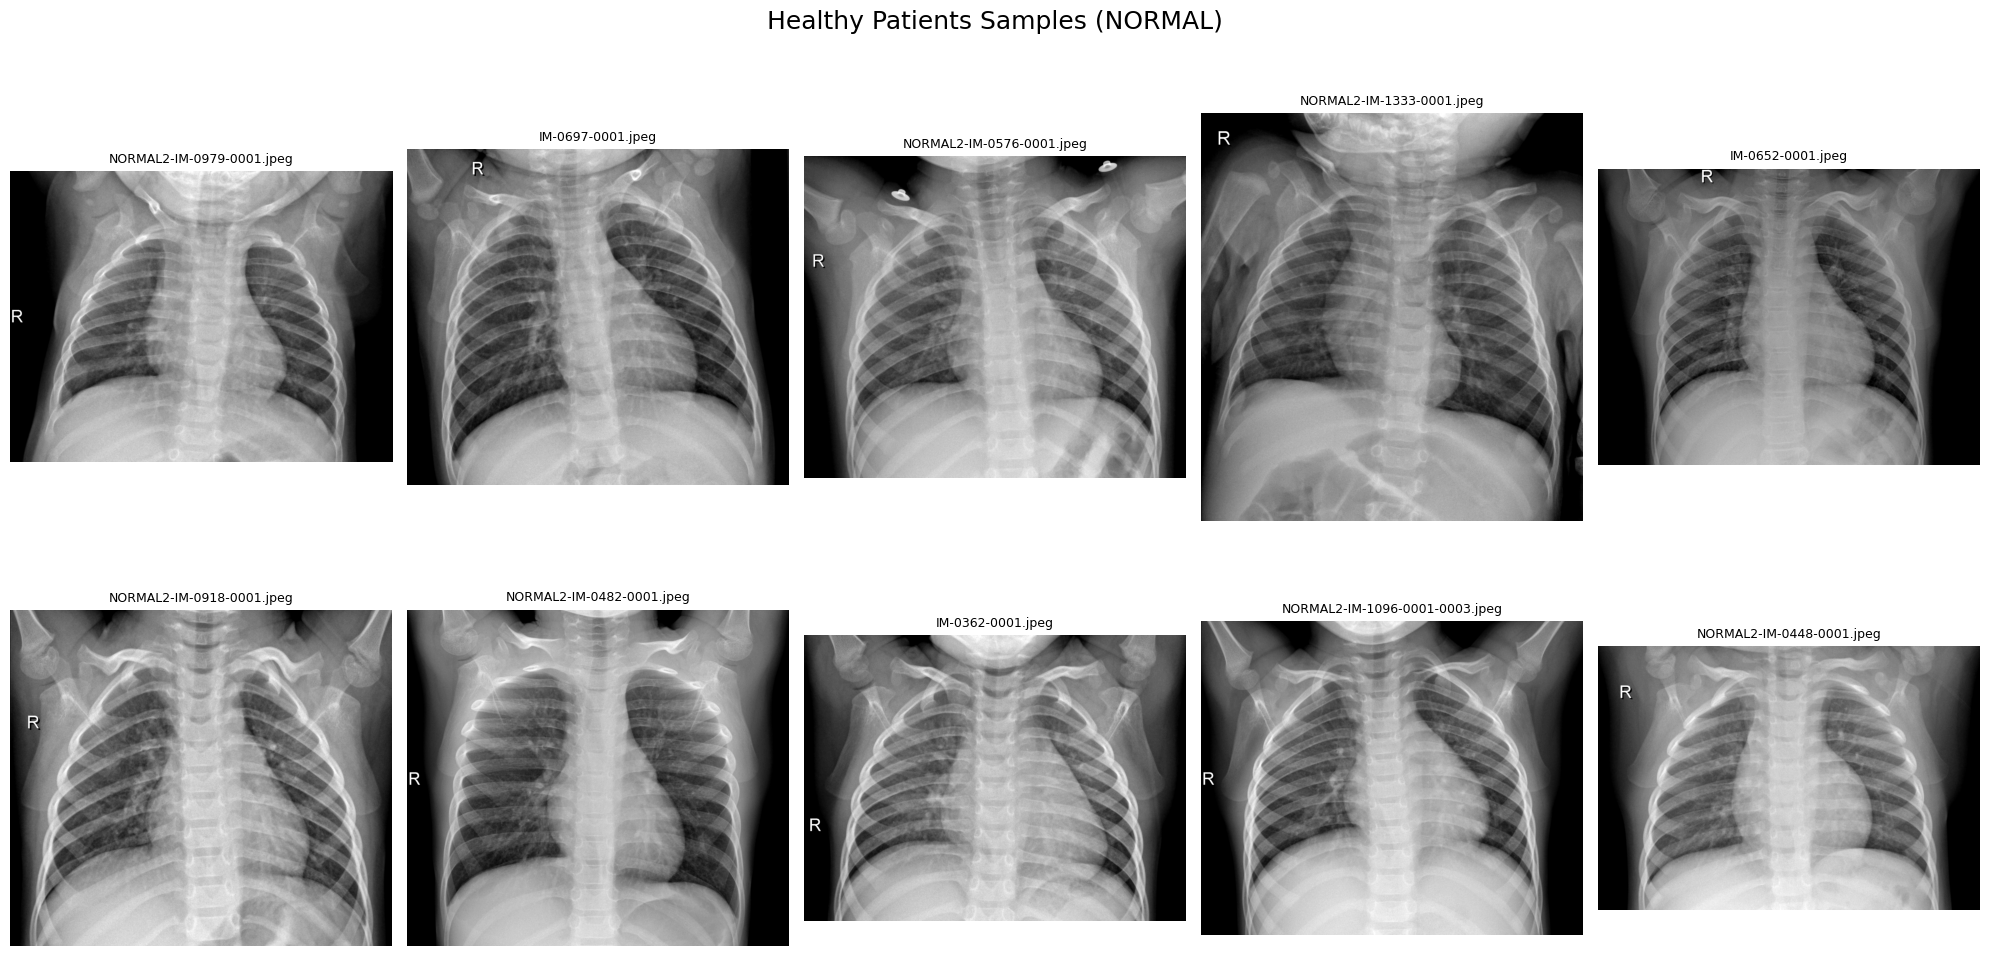

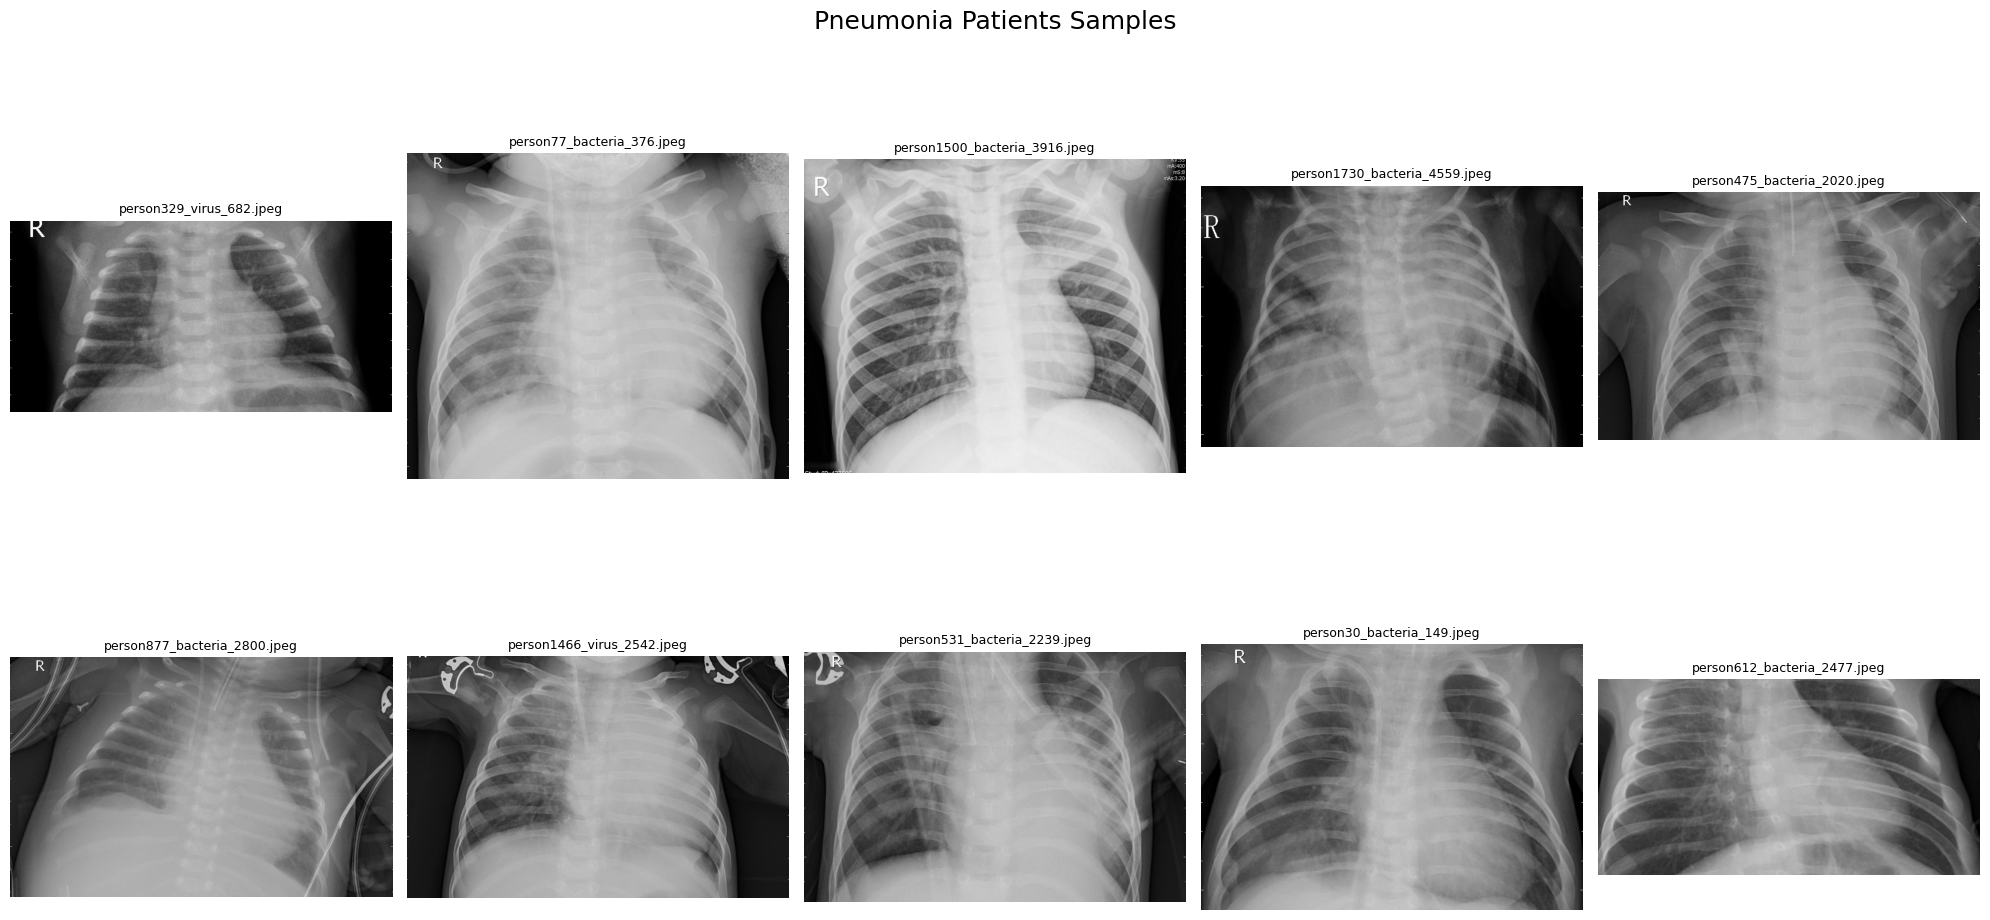

In [24]:
def show_samples_with_ids(dataset, class_idx, title, num_samples=15, fig_name="samples_examples.png", seed=50):
    # Set seed for reproducibility
    random.seed(seed)

    # Filter images belonging to the desired class
    class_imgs = [img_path for img_path, label in dataset.imgs if label == class_idx]
    
    # Shuffle and select sample images
    sampled_imgs = random.sample(class_imgs, min(num_samples, len(class_imgs)))

    # Plotting
    plt.figure(figsize=(20, 30))
    for i, img_path in enumerate(sampled_imgs):
        with Image.open(img_path) as img:
            plt.subplot(6, 5, i + 1)  # Adjust grid size if needed
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            img_id = os.path.basename(img_path)
            plt.title(img_id, fontsize=9)
    plt.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig(fig_name)
    plt.show()

# Example usage:
show_samples_with_ids(train_set, train_set.class_to_idx['NORMAL'], 'Healthy Patients Samples (NORMAL)', num_samples=10, fig_name = "healthy_samples_examples.png")
show_samples_with_ids(train_set, train_set.class_to_idx['PNEUMONIA'], 'Pneumonia Patients Samples', num_samples=10, fig_name =  "pneumonia_examples.png")

In [ ]:
import os
import shutil
import random
import numpy as np
from pathlib import Path
from PIL import Image
import torch
import torchvision.transforms as T
from tqdm import tqdm
import torch as nn

base_dir = '../ml4h_data/p2/part2/archive/chest_xray'
processed_dir = './filtered_balanced_chest_xray_dataset'

# 1. Filter images with extreme aspect ratios (>2.0 )
def filter_extreme_ratios(src_dir, dst_dir, max_ratio=2.0):
    if os.path.exists(dst_dir):
        shutil.rmtree(dst_dir)
    os.makedirs(dst_dir, exist_ok=True)
    for class_name in os.listdir(src_dir):
        class_src_path = os.path.join(src_dir, class_name)
        class_dst_path = os.path.join(dst_dir, class_name)
        os.makedirs(class_dst_path, exist_ok=True)
        for fname in os.listdir(class_src_path):
            img_path = os.path.join(class_src_path, fname)
            with Image.open(img_path) as img:
                w, h = img.size
                ratio = w / h
                if ratio <= max_ratio:
                    img.save(os.path.join(class_dst_path, fname))

# Filtering train set images
filtered_train_dir = os.path.join(processed_dir, 'filtered_train')
filter_extreme_ratios(os.path.join(base_dir, 'train'), filtered_train_dir)

filtered_trainset = ImageFolder(filtered_train_dir)

# 2. Balance classes via augmentation (using torchvision only)
def augmentation(dataset, target_dir):
    # Setup augmentation pipeline (torchvision version)
    augment = T.Compose([
        T.RandomApply([T.RandomAffine(degrees=10, translate=(0.1,0.1))], p=0.5),  # similar to elastic deformation
        T.RandomApply([T.GaussianBlur(kernel_size=5)], p=0.5),  # similar to slight gaussian noise
        T.RandomApply([T.RandomErasing(scale=(0.02, 0.1))], p=0.5)  # similar to cutout
    ])

    # Get paths of each class
    pneumonia_paths = [path for path, label in dataset.samples if label == dataset.class_to_idx['PNEUMONIA']]
    normal_paths = [path for path, label in dataset.samples if label == dataset.class_to_idx['NORMAL']]
    
    num_pneumonia = len(pneumonia_paths)
    num_normal = len(normal_paths)
    
    print(f"Pneumonia: {num_pneumonia}, Normal: {num_normal}")

    if num_pneumonia > num_normal:
        minority_class_paths = normal_paths
        majority_count = num_pneumonia
        minority_label = 'NORMAL'
    else:
        minority_class_paths = pneumonia_paths
        majority_count = num_normal
        minority_label = 'PNEUMONIA'

    num_to_augment = majority_count - len(minority_class_paths)
    times_to_augment = num_to_augment // len(minority_class_paths)
    remainder = num_to_augment % len(minority_class_paths)
    
    print(f"Augmenting '{minority_label}' images {times_to_augment} times each, plus {remainder} extra.")

    os.makedirs(target_dir, exist_ok=True)

    # Copy all majority images and minority originals
    for img_path, label in tqdm(dataset.samples, desc="Copying original images"):
        class_label = dataset.classes[label]
        class_dir = os.path.join(target_dir, class_label)
        os.makedirs(class_dir, exist_ok=True)
        shutil.copy(img_path, class_dir)

    # Augment minority class
    augmented_count = 0
    for idx, img_path in tqdm(enumerate(minority_class_paths), total=len(minority_class_paths), desc="Augmenting minority class"):
        image = Image.open(img_path).convert('L')  # Convert to grayscale manually (important)
        base_filename = Path(img_path).stem
        class_dir = os.path.join(target_dir, minority_label)

        for i in range(times_to_augment + (1 if idx < remainder else 0)):
            # Apply augmentations
            img_tensor = T.ToTensor()(image)  # convert to tensor
            augmented_img_tensor = augment(img_tensor)
            augmented_img_tensor = torch.clamp(augmented_img_tensor, 0, 1)  # Ensure pixel values are valid

            # Convert back to PIL Image
            augmented_img_pil = T.ToPILImage()(augmented_img_tensor)

            aug_filename = f"{base_filename}_aug_{i}.jpeg"
            os.makedirs(class_dir, exist_ok=True)
            augmented_img_pil.save(os.path.join(class_dir, aug_filename))
            augmented_count += 1

    print(f"Total augmented images added: {augmented_count}")

# Apply augmentation to balance dataset
balanced_train_dir = os.path.join(processed_dir, 'balanced_train')
augmentation(filtered_trainset, balanced_train_dir)

# Check final balanced distribution
balanced_trainset = ImageFolder(balanced_train_dir)

def check_label_distribution(dataset, title):
    counts = [0] * len(dataset.classes)
    for _, label in dataset.samples:
        counts[label] += 1
    plt.bar(dataset.classes, counts)
    plt.title(title)
    plt.ylabel('Number of Images')
    plt.xlabel('Class')
    plt.show()
    print(dict(zip(dataset.classes, counts)))

check_label_distribution(balanced_trainset, 'Final Balanced Training Set Distribution')

# 3. Standardize to fixed size (e.g., 224x224)
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # Grayscale images
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Simple normalization for grayscale
])

balanced_trainset_transformed = ImageFolder(balanced_train_dir, transform=transform)

# Visualize final augmented and normalized images
def visualize_images(dataset, num_images=6):
    loader = torch.utils.data.DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(loader))
    images = images.numpy().transpose((0, 2, 3, 1))
    images = images * 0.5 + 0.5  # Denormalize
    plt.figure(figsize=(15,5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i,:,:,0], cmap='gray')
        plt.title(dataset.classes[labels[i]])
        plt.axis('off')
    plt.show()

visualize_images(balanced_trainset_transformed)

Pneumonia: 3759, Normal: 1341
Augmenting 'NORMAL' images 1 times each, plus 1077 extra.


Augmenting minority class:  45%|████▍     | 601/1341 [08:07<07:09,  1.72it/s]

In [ ]:
# Define where to save the final preprocessed images
final_save_dir = './final_preprocessed_dataset/train'

if not os.path.exists(final_save_dir):
    os.makedirs(final_save_dir)

# Save images
for class_name in balanced_trainset_transformed.classes:
    class_dir = os.path.join(final_save_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

# Go through the dataset and save images
for idx, (img, label) in tqdm(enumerate(balanced_trainset_transformed), total=len(balanced_trainset_transformed)):
    class_name = balanced_trainset_transformed.classes[label]
    save_path = os.path.join(final_save_dir, class_name, f'image_{idx:05d}.png')  # Saving as PNG (you can also choose .jpg)

    # Since the tensor is normalized [-1,1] → denormalize it back to [0,1] before saving
    img = img * 0.5 + 0.5
    save_image(img, save_path)

In [ ]:
# Create transform for validation and test sets
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load the original val and test datasets
val_dataset = datasets.ImageFolder(os.path.join(base_dir, 'val'), transform=basic_transform)
test_dataset = datasets.ImageFolder(os.path.join(base_dir, 'test'), transform=basic_transform)

# Where to save
final_val_save_dir = './final_preprocessed_dataset/val'
final_test_save_dir = './final_preprocessed_dataset/test'

# Function to save dataset
def save_dataset(dataset, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for class_name in dataset.classes:
        class_dir = os.path.join(save_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

    for idx, (img, label) in tqdm(enumerate(dataset), total=len(dataset)):
        class_name = dataset.classes[label]
        save_path = os.path.join(save_dir, class_name, f'image_{idx:05d}.png')

        # Denormalize before saving
        img = img * 0.5 + 0.5
        save_image(img, save_path)

# Save validation set
save_dataset(val_dataset, final_val_save_dir)

# Save test set
save_dataset(test_dataset, final_test_save_dir)

### Question 1.2

In [2]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Define paths to the preprocessed datasets
train_dir = './final_preprocessed_dataset/train'
val_dir = './final_preprocessed_dataset/val'
test_dir = './final_preprocessed_dataset/test'

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

Epoch [1/10], Train Loss: 0.2728, Val Loss: 0.2516


Epoch [2/10], Train Loss: 0.0961, Val Loss: 0.1314


Epoch [3/10], Train Loss: 0.0741, Val Loss: 0.2468


Epoch [4/10], Train Loss: 0.0587, Val Loss: 0.0718


Epoch [5/10], Train Loss: 0.0463, Val Loss: 0.0240


Epoch [6/10], Train Loss: 0.0350, Val Loss: 0.3108


Epoch [7/10], Train Loss: 0.0317, Val Loss: 0.2031


Epoch [8/10], Train Loss: 0.0218, Val Loss: 0.1315


Epoch [9/10], Train Loss: 0.0199, Val Loss: 0.2514


Epoch [10/10], Train Loss: 0.0200, Val Loss: 0.2148


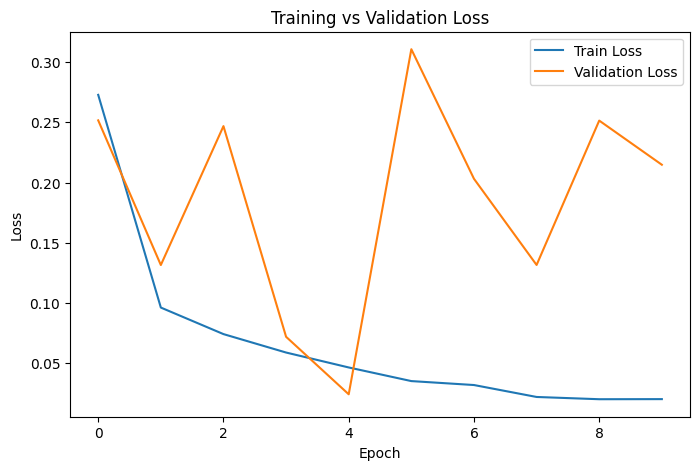

              precision    recall  f1-score   support

      NORMAL       0.97      0.30      0.46       234
   PNEUMONIA       0.70      0.99      0.82       390

    accuracy                           0.74       624
   macro avg       0.84      0.65      0.64       624
weighted avg       0.80      0.74      0.69       624

Balanced Accuracy: 0.6491
F1 Score (weighted): 0.6889


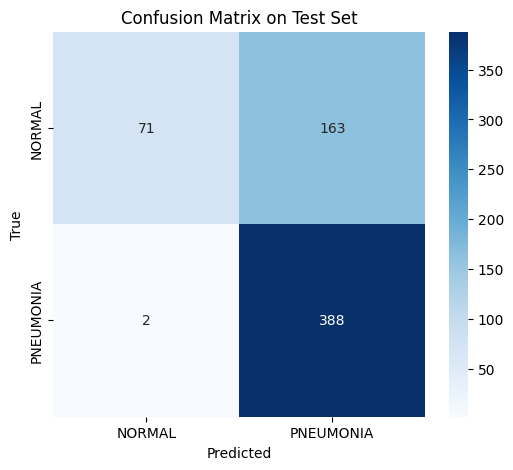

In [3]:
import torch
import torch.nn as nn
from torchvision import models

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = 0
    loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score

# Evaluate on Test Set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# Report
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

# Balanced Accuracy & F1 Score
balanced_acc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')  # use 'macro' if you want unweighted per-class avg

print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()

Epoch [10/10], Train Loss: 0.0750, Val Loss: 0.4065


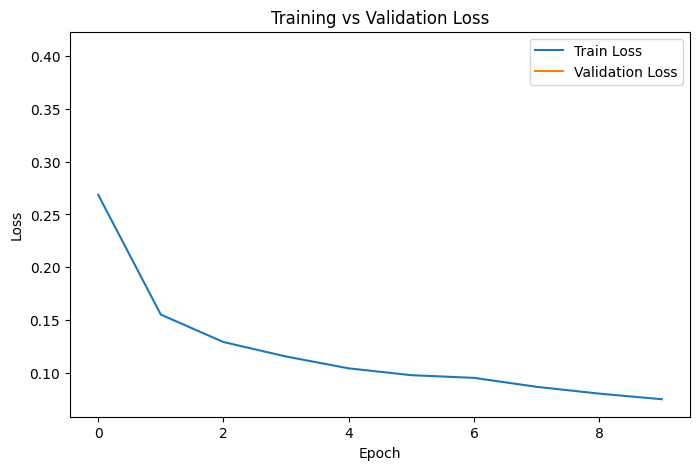

Finished Training
              precision    recall  f1-score   support

      NORMAL       0.95      0.69      0.80       234
   PNEUMONIA       0.84      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624

Balanced Accuracy: 0.8338
F1 Score (weighted): 0.8647


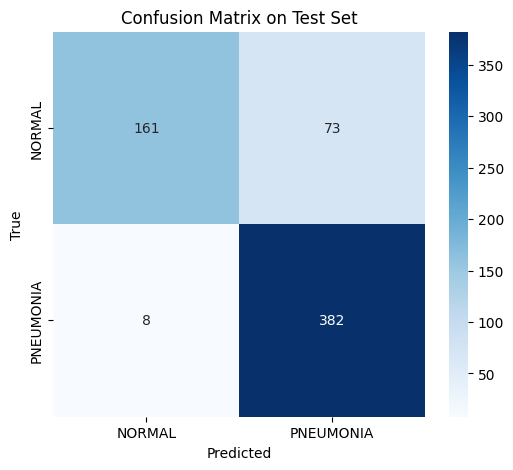

In [4]:
import torch
import torch.nn as nn
from torchvision import models

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Transformation: resize, convert to grayscale, normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Define paths to the preprocessed datasets
train_dir = './final_preprocessed_dataset/train'
val_dir = './final_preprocessed_dataset/val'
test_dir = './final_preprocessed_dataset/test'

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)#I could use ResNet50 to check performance

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pretrained ResNet50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Freeze early layers (optional for fine-tuning)
for param in resnet50.parameters():
    param.requires_grad = False

# Replace the fully connected layer
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 2)  # Two output classes

model = resnet50.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

USE_PRETRAINED_MODEL = False

if USE_PRETRAINED_MODEL:
    print("Using existing trained model")
    model.load_state_dict(torch.load('models/resnet50_xray_neumonia.pt'))

else:
    
    # Training loop
    num_epochs = 10
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = 0
    loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Plot Training and Validation Loss
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    print('Finished Training')
    torch.save(model.state_dict(), './models/resnet50_xray_neumonia.pt')

from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score

# Evaluate on Test Set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# Report
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

# Balanced Accuracy & F1 Score
balanced_acc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')  # use 'macro' if you want unweighted per-class avg

print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()